# Detecting Breast Cancer
This notebook demonstrates a machine learning workflow to detect breast cancer using Python, data preprocessing, and model evaluation techniques.

**Author:** [Your Name]  
**Description:** Preprocessing, training, and evaluation of ML models for breast cancer detection.

In [39]:
pip install -q cleanvision

In [45]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from cleanvision import Imagelab
from matplotlib import ticker
from PIL import Image
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For reproducability
SEED = 51432
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Customize matplotlib graphs
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif", size=10.5)

# Introduction

Breast cancer is the *most prevalent* form of cancer, accounting for **2,261,419** (11.7%) of the **19,292,789** cases reported worldwide in 2020 - [Global Cancer Observatory][gco].

[gco]: https://gco.iarc.fr/today/data/factsheets/cancers/39-All-cancers-fact-sheet.pdf

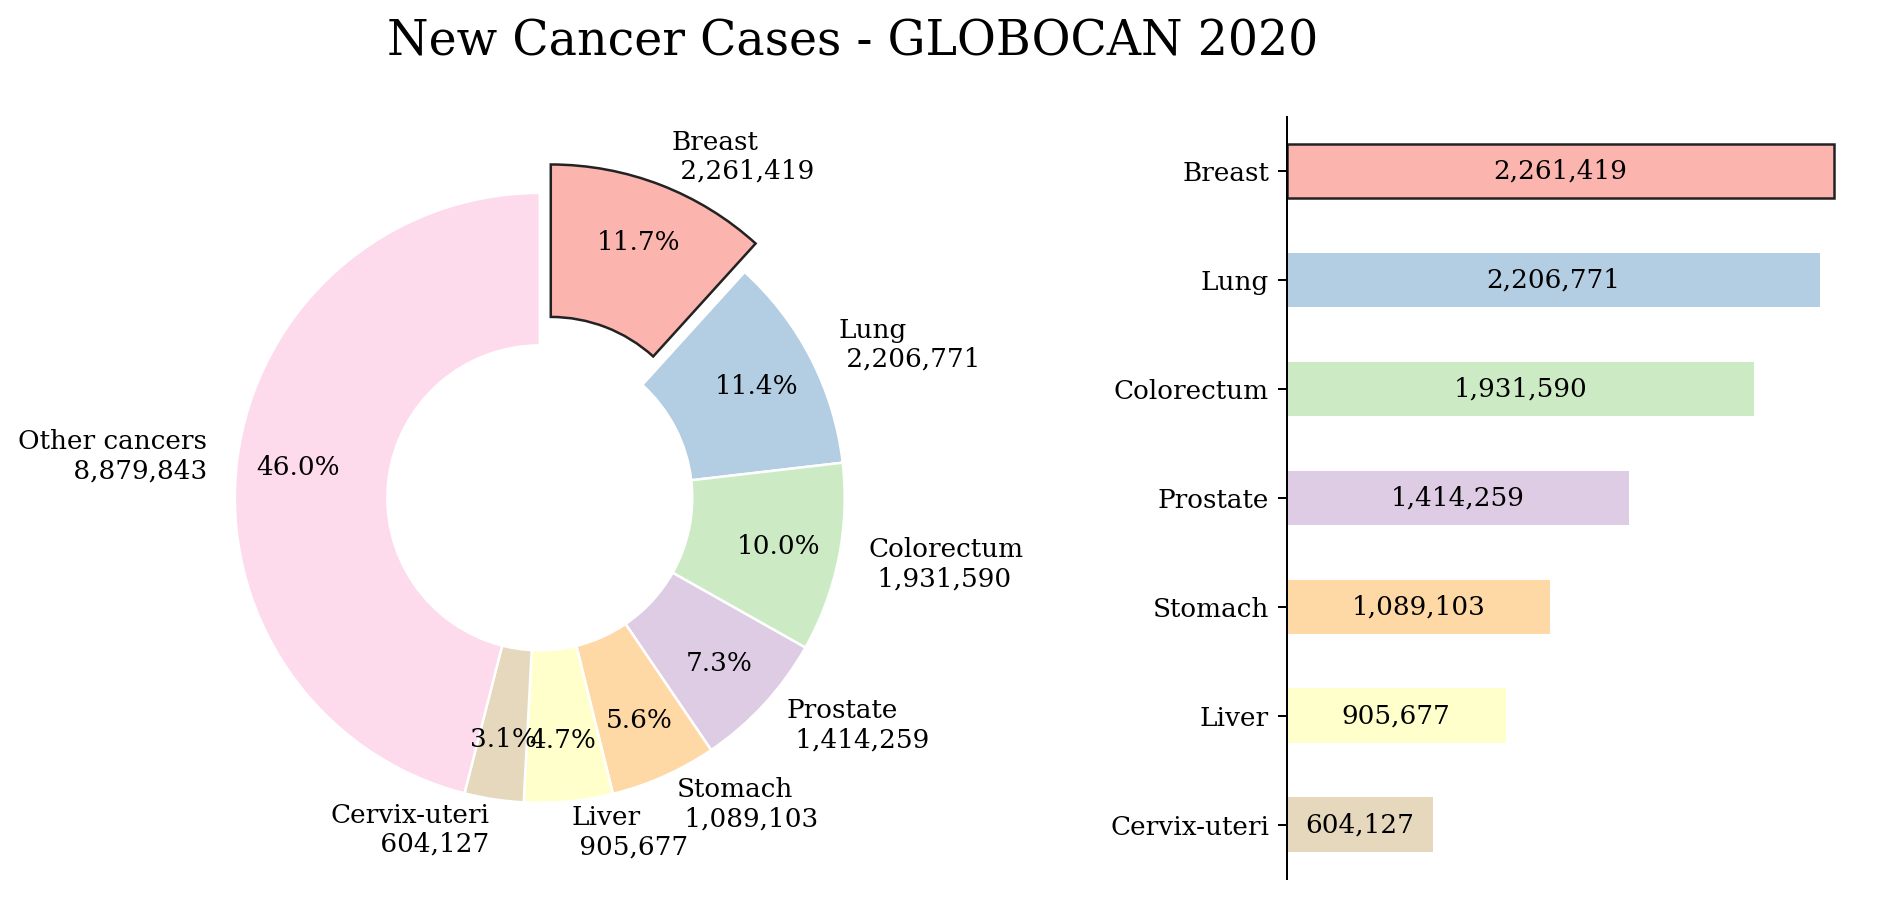

In [46]:
cancer_data = pd.Series({
    "Breast": 2261419,
    "Lung": 2206771,
    "Colorectum": 1931590,
    "Prostate": 1414259,
    "Stomach": 1089103,
    "Liver": 905677,
    "Cervix-uteri": 604127,
    "Other cancers": 8879843
})
fig, axes = plt.subplot_mosaic("aab", figsize=(14, 5.5), dpi=180)
fig.suptitle("New Cancer Cases - GLOBOCAN 2020", size=19, weight=500)
pie_chart = cancer_data.plot.pie(colors=plt.colormaps["Pastel1"].colors, startangle=90,
                                 autopct=lambda x: f"{x:.1f}%", pctdistance=0.8,
                                 explode=[0.1] + [0]*7, counterclock=False,
                                 ax=axes["a"], wedgeprops=dict(width=0.5, edgecolor='w'),
                                 labels=[f"{kind}\n {count:,}"
                                         for kind, count in cancer_data.items()])
axes["a"].axis("off")

cancer_data_specific = cancer_data.drop("Other cancers").sort_values()
bar_chart = cancer_data_specific.plot.barh(ax=axes["b"],
                                           color=plt.colormaps["Pastel1"].colors[-3:: -1])
bar_chart.bar_label(bar_chart.containers[0], [f"{x:,}" for x in cancer_data_specific],
             label_type="center"
)
axes["b"].spines["bottom"].set_visible(False)
axes["a"].patches[0].set_edgecolor("#222")
axes["b"].patches[-1].set_edgecolor("#222")
axes["b"].xaxis.set_visible(False);

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis

The file `Folds.csv` outlines a 5-fold cross-validation strategy which was designed such that training and test images are from different individuals:

Each fold contains all 7,909 available images. We will use the second fold for this study, since it has the highest proportion of training images:

In [48]:
selected_fold_data["filename"] = ("/content/drive/MyDrive/data/"
                                  + selected_fold_data["filename"])

In [49]:
selected_fold_data["filename"] = ("/content/drive/MyDrive/data/"
                                  + selected_fold_data["label"] + "/" # Added this line
                                  + selected_fold_data["filename"])

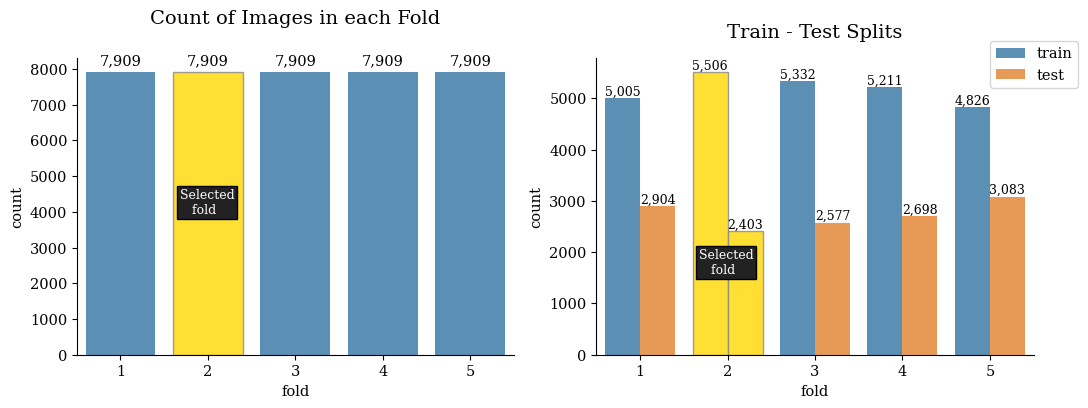

In [50]:
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold")\
                              .copy().reset_index(drop=True)
selected_fold_data["filename"] = ("/content/drive/MyDrive/data/"
                                  + selected_fold_data["label"] + "/" # Added this to insert the label folder
                                  + selected_fold_data["filename"]) # Now combines: /content/drive/MyDrive/data/ + benign/ + ...
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4.2), tight_layout=True)
# Plot image count in each fold
sb.countplot(data=fold_info, x="fold", color="C0", ax=ax1, alpha=0.8)
bars = ax1.containers[0]
ax1.bar_label(bars, padding=3,
             labels=[f"{x:,.0f}" for x in bars.datavalues])
_selected_bar = bars[selected_fold - 1]
_selected_bar.set_facecolor("gold")
_selected_bar.set_edgecolor("#888")
ax1.text(_selected_bar.get_x() + 0.08, _selected_bar.get_height() / 2,
         "Selected\n   fold", size=9, color="#fff",
         bbox={"pad": 2, "facecolor": "#222"})
ax1.set_title("Count of Images in each Fold", size=14, pad=25)

# Plot train-test split
sb.countplot(data=fold_info, x="fold", hue="grp", palette="tab10",
              ax=ax2, alpha=0.8)
for bars in ax2.containers:
    ax2.bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    bars[selected_fold - 1].set_facecolor("gold")
    bars[selected_fold - 1].set_edgecolor("#888")
ax2.text(_selected_bar.get_x() + 0.07, _selected_bar.get_height() / 5,
         "Selected\n   fold", size=9, color="#fff",
         bbox={"pad": 2, "facecolor": "#222"})
ax2.set_title("Train - Test Splits", size=14, pad=15)
ax2.legend(loc=(0.9, 0.9));

In [51]:
# Assuming 'fold_info' is a DataFrame with columns 'filename', 'label', 'fold', etc.
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold")\
                              .copy().reset_index(drop=True)
selected_fold_data["filename"] = ("/content/drive/MyDrive/data/"
                                  + selected_fold_data["label"] + "/" # Added this to insert the label folder
                                  + selected_fold_data["filename"]) # Now combines: /content/drive/MyDrive/data/ + benign/ + ...

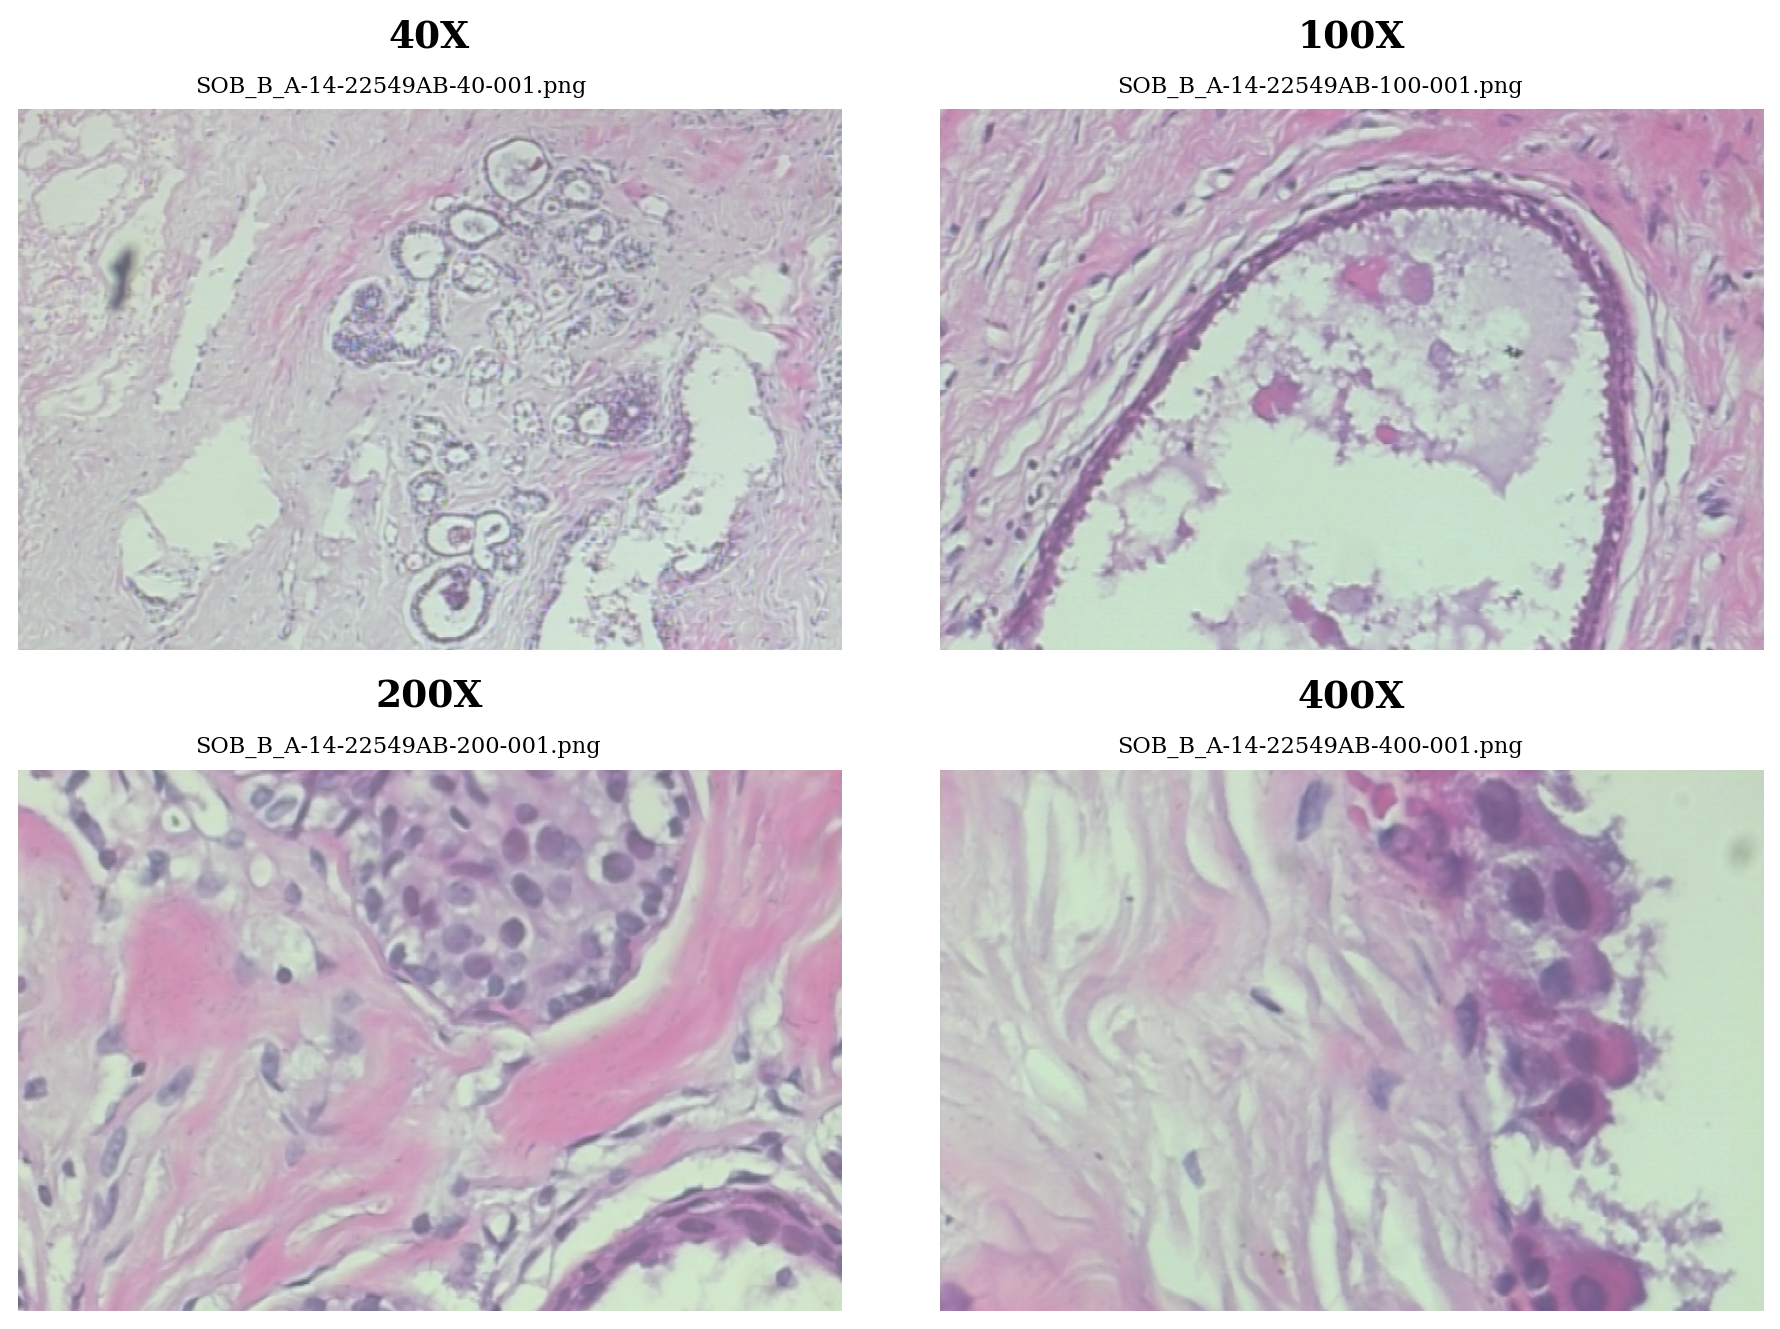

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7.5), dpi=180, tight_layout=True)
sample_images = selected_fold_data.groupby("mag", as_index=False).first()
for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)
    ax.imshow(img)
    ax.set_title(f"{row.mag}X", size=15, pad=25, weight=600)
    ax.text(150, -15, row.filename.split("/")[-1], size=9)
    ax.axis("off")

## Image Validation

There are about 256 (3.16%) duplicate images. On inspection, duplicated pairs have similar slide-ID but different tumour types; which might suggest that those slides capture more than 1 tumour type (and perhaps also human error).

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7909 [00:00<?, ?it/s]

  0%|          | 0/7909 [00:00<?, ?it/s]

Issue checks completed. 330 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          250 |
|  1 | odd_size         |           74 |
|  2 | near_duplicates  |            6 |
|  3 | dark             |            0 |
|  4 | light            |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | low_information  |            0 |
|  7 | blurry           |            0 |
|  8 | grayscale        |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 250
Examples representing most severe instances of this issue:

Set: 0


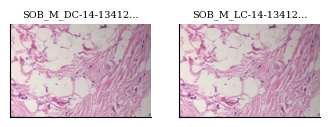

Set: 1


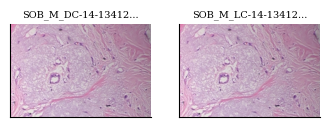

Set: 2


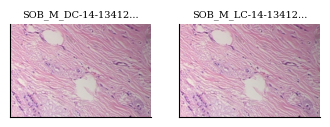

Set: 3


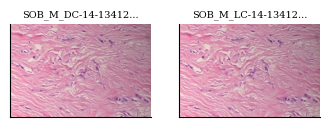

--------------------- odd_size images ----------------------

Number of examples with this issue: 74
Examples representing most severe instances of this issue:



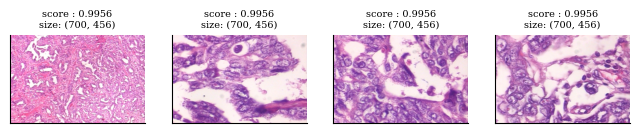

------------------ near_duplicates images ------------------

Number of examples with this issue: 6
Examples representing most severe instances of this issue:

Set: 0


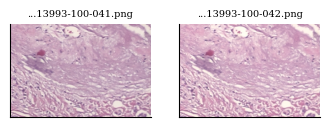

Set: 1


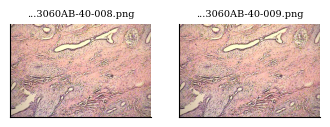

Set: 2


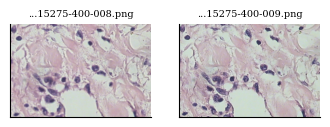

In [53]:
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()
imagelab.report(verbosity=4)

In [54]:
duplicated_images = imagelab.issues[
    ["is_exact_duplicates_issue", "is_near_duplicates_issue"]
].any(axis=1).reset_index().rename(columns={"index": "filename", 0: "duplicated"})
duplicated_images.head()

filename  duplicated
0  /content/drive/MyDrive/data/benign/BreaKHis_v1...       False
1  /content/drive/MyDrive/data/benign/BreaKHis_v1...       False
2  /content/drive/MyDrive/data/benign/BreaKHis_v1...       False
3  /content/drive/MyDrive/data/benign/BreaKHis_v1...       False
4  /content/drive/MyDrive/data/benign/BreaKHis_v1...       False

In [55]:
# Check that filenames align
assert duplicated_images["filename"].equals(selected_fold_data["filename"])

# Drop all duplicated images, then validate again
selected_fold_data = selected_fold_data[~duplicated_images["duplicated"]]
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7653 [00:00<?, ?it/s]

  0%|          | 0/7653 [00:00<?, ?it/s]

Issue checks completed. 74 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


In [56]:
# Use data in selected fold (2) with magnification factor >= 200X
train = selected_fold_data.query("mag >= 200 and grp == 'train'")
test = selected_fold_data.query("mag >= 200 and grp == 'test'")
train.shape, test.shape

((2566, 5), (1149, 5))

## Target Distribution

There are significantly more images of *malignant* cases than there are of *benign* ones:

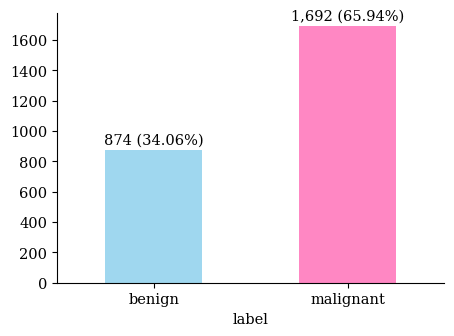

In [57]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["skyblue", "hotpink"], alpha=0.8,
                           figsize=(5, 3.5))
ax.bar_label(ax.containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);

In [58]:
y = train["label"].map(classes)
positive_only_preds = np.ones_like(y)
print(f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2%}",
      f"\nROC-AUC:  {metrics.roc_auc_score(y, positive_only_preds):.2%}")

Accuracy: 65.94% 
ROC-AUC:  50.00%




We will thus use [ROC-AUC][roc] and a [confusion matrix][cmat] for model evaluation.

[cmat]: https://en.wikipedia.org/wiki/Confusion_matrix
[roc]: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

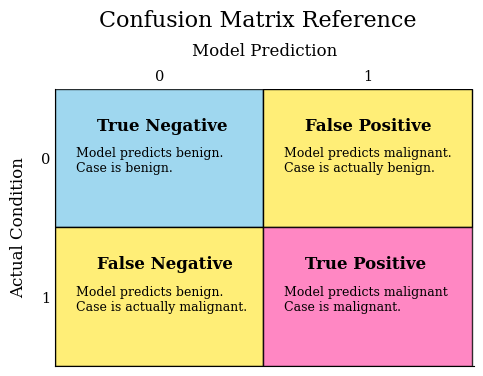

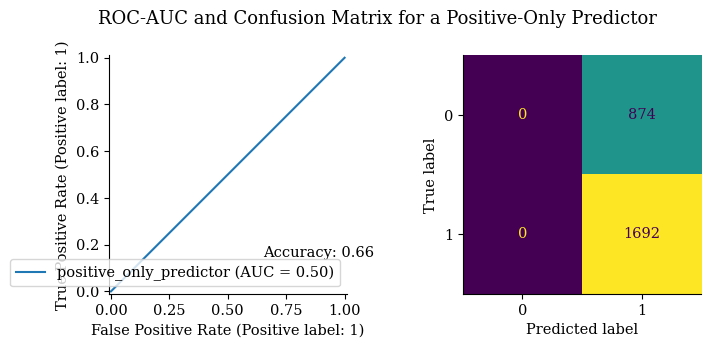

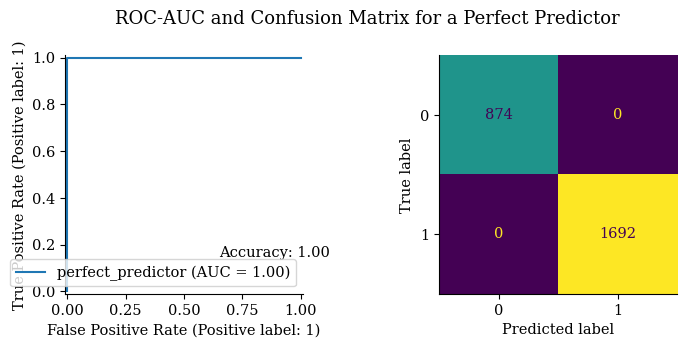

In [59]:
# Draw a confusion matrix with descriptions
fig, ax = plt.subplots(figsize=(5.4, 3.6))
ax.axvspan(0, 0.5, 0.5, 1, facecolor="skyblue", alpha=0.8, edgecolor="black")
ax.axvspan(0.5, 1, 0.5, 1, facecolor="#fe7", edgecolor="black")
ax.axvspan(0, 0.5, 0, 0.5, facecolor="#fe7", edgecolor="black")
ax.axvspan(0.5, 1, 0, 0.5, facecolor="hotpink", alpha=0.8, edgecolor="black")
ax.text(0.1, 0.85, "True Negative", size=12, weight=600)
ax.text(0.05, 0.7, "Model predicts benign.\nCase is benign.", size=9)
ax.text(0.6, 0.85, "False Positive", size=12, weight=600)
ax.text(0.55, 0.7, "Model predicts malignant.\nCase is actually benign.", size=9)
ax.text(0.1, 0.35, "False Negative", size=12, weight=600)
ax.text(0.05, 0.2, "Model predicts benign.\nCase is actually malignant.", size=9)
ax.text(0.6, 0.35, "True Positive", size=12, weight=600)
ax.text(0.55, 0.2, "Model predicts malignant\nCase is malignant.", size=9)
ax.set_xlim(0, 1.005)
ax.xaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.xaxis.set_ticklabels([0, 1])
ax.yaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.yaxis.set_ticklabels([1, 0])
ax.set_ylabel("Actual Condition", size=12, labelpad=10)
ax.set_xlabel("Model Prediction", size=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")
ax.spines["left"].set_position("zero")
ax.tick_params(pad=0, top=False, left=False)
fig.suptitle("Confusion Matrix Reference", y=1.1, size=16)

# Plot metrics for positive-only-predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, positive_only_preds, ax=ax1,
                                         name="positive_only_predictor")
metrics.ConfusionMatrixDisplay.from_predictions(y, positive_only_preds,
                                                ax=ax2, colorbar=False)
ax1.text(0.65, 0.15,
         f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2f}")
fig.suptitle("ROC-AUC and Confusion Matrix for a Positive-Only Predictor", size=13)

# Plot metrics for "perfect" predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, y, ax=ax1, name="perfect_predictor")
ax1.text(0.65, 0.15, f"Accuracy: {metrics.accuracy_score(y, y):.2f}")
metrics.ConfusionMatrixDisplay.from_predictions(y, y, ax=ax2, colorbar=False)
fig.suptitle("ROC-AUC and Confusion Matrix for a Perfect Predictor", size=13);

In [60]:
IMG_SIZE = 224
BATCH_SIZE = 28


def load_image(filename: str, label: int) -> Tuple[tf.Tensor, str]:
    file = tf.io.read_file(filename)
    img = tf.image.decode_png(file, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    return img, label


# Prepare training and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(
    train["filename"], train["label"].map(classes), random_state=SEED
)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
             .map(load_image).batch(BATCH_SIZE)
validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))\
                  .map(load_image).batch(BATCH_SIZE)
# Prepare test dataset
test = test.sample(frac=1, random_state=SEED)  # shuffle test data
test_ds = tf.data.Dataset.from_tensor_slices(
    (test["filename"], test["label"].map(classes))
).map(load_image).batch(BATCH_SIZE)

# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Let's have a look at some of the images:

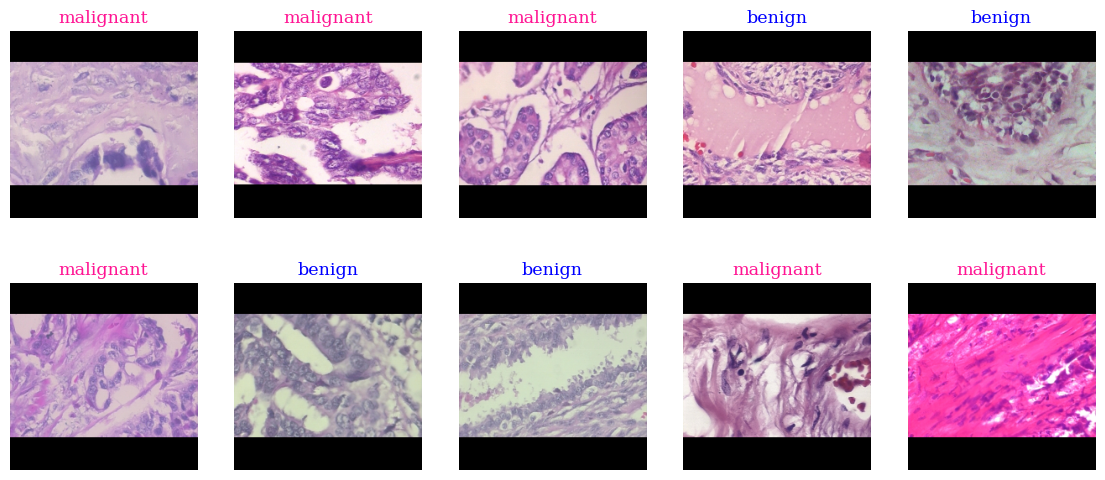

In [61]:
plt.figure(figsize=(14, 6))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        label = class_names[labels[i]]
        title_color = "blue" if label == "benign" else "deeppink"
        plt.title(class_names[labels[i]], color=title_color)
        plt.axis("off")

In [62]:
sample_image = load_image(*train[["filename", "label"]].iloc[0])[0]


def plot_augmentations(augmentation_layer: tf.keras.layers.Layer) -> None:
    augment_name = augmentation_layer.name
    fig, (ax0, *axes) = plt.subplots(ncols=4, figsize=(15, 4))
    ax0.imshow(sample_image.numpy().astype("uint8"))
    ax0.set_title("Original", size=14, pad=10)
    ax0.axis("off")
    for idx, ax in enumerate(axes):
        augmented_image = augmentation_layer(sample_image)
        ax.imshow(augmented_image.numpy().astype("uint8"))
        ax.set_title(augment_name.title(), size=14, pad=10)
        ax.axis("off")

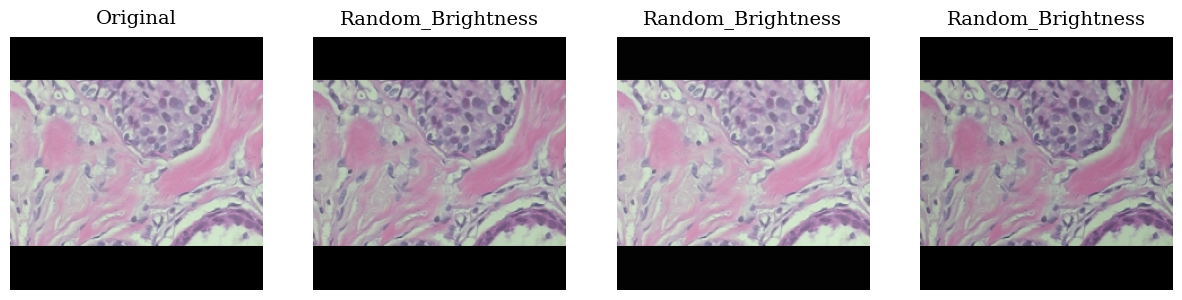

In [63]:
plot_augmentations(layers.RandomBrightness(0.2))

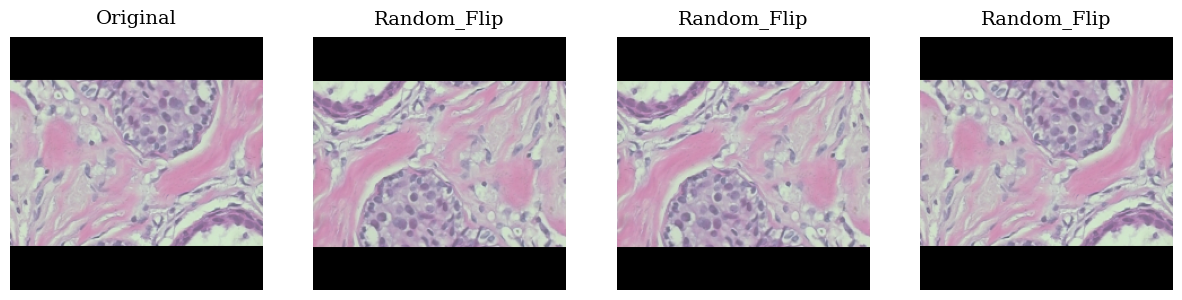

In [64]:
plot_augmentations(layers.RandomFlip())

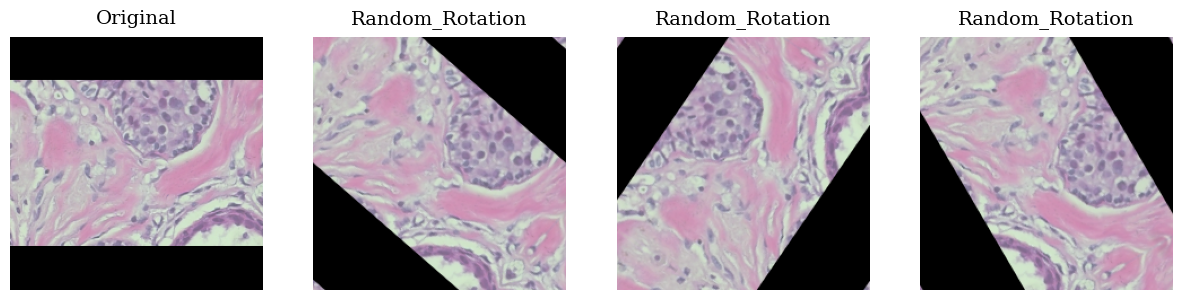

In [65]:
plot_augmentations(layers.RandomRotation(0.2, seed=SEED))

## Helper functions

In [71]:
MAX_EPOCHS = 25
BASE_LEARNING_RATE = 0.001


def compile_and_fit_model(
    model: tf.keras.Model,
    learning_rate: float=BASE_LEARNING_RATE,
    epochs: int=MAX_EPOCHS
) -> tf.keras.callbacks.History:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name="roc_auc"), "binary_accuracy"]
    )
    early_stopping = EarlyStopping(min_delta=1e-4, patience=5, verbose=1,
                                   restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)
    history = model.fit(train_ds, validation_data=validation_ds,
                        epochs=epochs, callbacks=[early_stopping, reduce_lr])
    # Plot training metrics
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
    for ax, metric in zip(axes.flat, ["Accuracy", "Loss"]):
        performance_df.filter(like=metric.lower()).plot(ax=ax)
        ax.set_title(metric, size=14, pad=10)
        ax.set_xlabel("epoch")
    return history


def evaluate_model(model: tf.keras.Model, dataset: tf.data.Dataset=test_ds) -> None:
    loss, auc, accuracy = model.evaluate(dataset, verbose=0)
    print(f"\nROC-AUC:   {auc:.5f}",
          f"Accuracy:  {accuracy:.5f}",
          f"Loss:      {loss:.5f}\n", sep="\n")
    # Get labels and predictions for each batch in dataset
    results = [(labels, model.predict(images, verbose=0).reshape(-1))
               for images, labels in dataset.take(-1)]
    labels = np.concatenate([x[0] for x in results])
    preds = np.concatenate([x[1] for x in results])
    # Plot metrics
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
    curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
    for ax, curve in zip(axes[:2], curves):
        curve.from_predictions(labels, preds, ax=ax, name=model.name)
    metrics.ConfusionMatrixDisplay.from_predictions(
        labels, preds.round().astype("uint8"), ax=axes[2], colorbar=False,
    )
    titles = ["ROC-AUC Curve", "Precision-Recall Curve", "Confusion Matrix"]
    for ax, title in zip(axes.flat, titles):
        ax.set_title(title, size=14, pad=10)


def plot_predictions(model: tf.keras.Model) -> None:
    plt.figure(figsize=(14, 9))
    for images, labels in test_ds.take(1):
        labels = labels.numpy()
        predicted_labels = model.predict(images).round().astype("uint8").reshape(-1,)
        print("Predicted:", predicted_labels)
        print("Actual:   ", labels)
        for i, (pred, actual) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(4, 7, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if pred == actual:
                plt.title(class_names[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_names[predicted_labels[i]]}\n"
                          + f"(Actual: {class_names[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

# Custom Convolutional Neural Network

A [Convolutional Neural Network][cnn] (CNN) is a class of artificial neural networks that is well suited for computer vision problems. It excels at finding patterns (features) in images (see [introduction to CNNs][cnn-intro]).

[cnn]: https://en.wikipedia.org/wiki/Convolutional_neural_network
[cnn-intro]: https://www.kaggle.com/code/ryanholbrook/the-convolutional-classifier

In [72]:
custom_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # Convolutional block I
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Convolutional block II
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Convolutional block III
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Fully connected layers
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="CustomCNN")
custom_model.summary()

Model: "CustomCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_brightness_2                  │ (None, 224, 224, 3)         │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_2 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,541 (525.55 KB)

 Trainable params: 134,535 (525.53 KB)

 Non-trainable params: 6 (24.00 B)

Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 308s 4s/step - binary_accuracy: 0.6878 - loss: 0.5898 - roc_auc: 0.6724 - val_binary_accuracy: 0.7586 - val_loss: 0.4865 - val_roc_auc: 0.8688 - learning_rate: 0.0010
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 288s 4s/step - binary_accuracy: 0.8174 - loss: 0.4660 - roc_auc: 0.8527 - val_binary_accuracy: 0.7601 - val_loss: 0.4811 - val_roc_auc: 0.8799 - learning_rate: 0.0010
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - binary_accuracy: 0.8430 - loss: 0.4278 - roc_auc: 0.8610 - val_binary_accuracy: 0.8598 - val_loss: 0.4169 - val_roc_auc: 0.8813 - learning_rate: 0.0010
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - binary_accuracy: 0.8357 - loss: 0.3952 - roc_auc: 0.8725 - val_binary_accuracy: 0.8614 - val_loss: 0.4220 - val_roc_auc: 0.8943 - learning_rate: 0.0010
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - binary_accuracy: 0.8314 - loss: 0.4315 - roc_auc: 0.8621 - val_binary_accuracy: 0.8520 - val_loss: 0.3845 - val_roc_auc: 0.8856

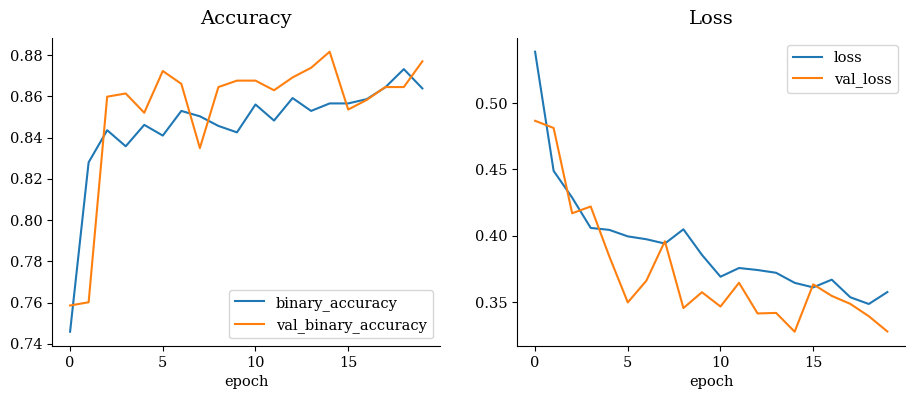

In [68]:
custom_history = compile_and_fit_model(custom_model)


ROC-AUC:   0.82332
Accuracy:  0.85988
Loss:      0.51149



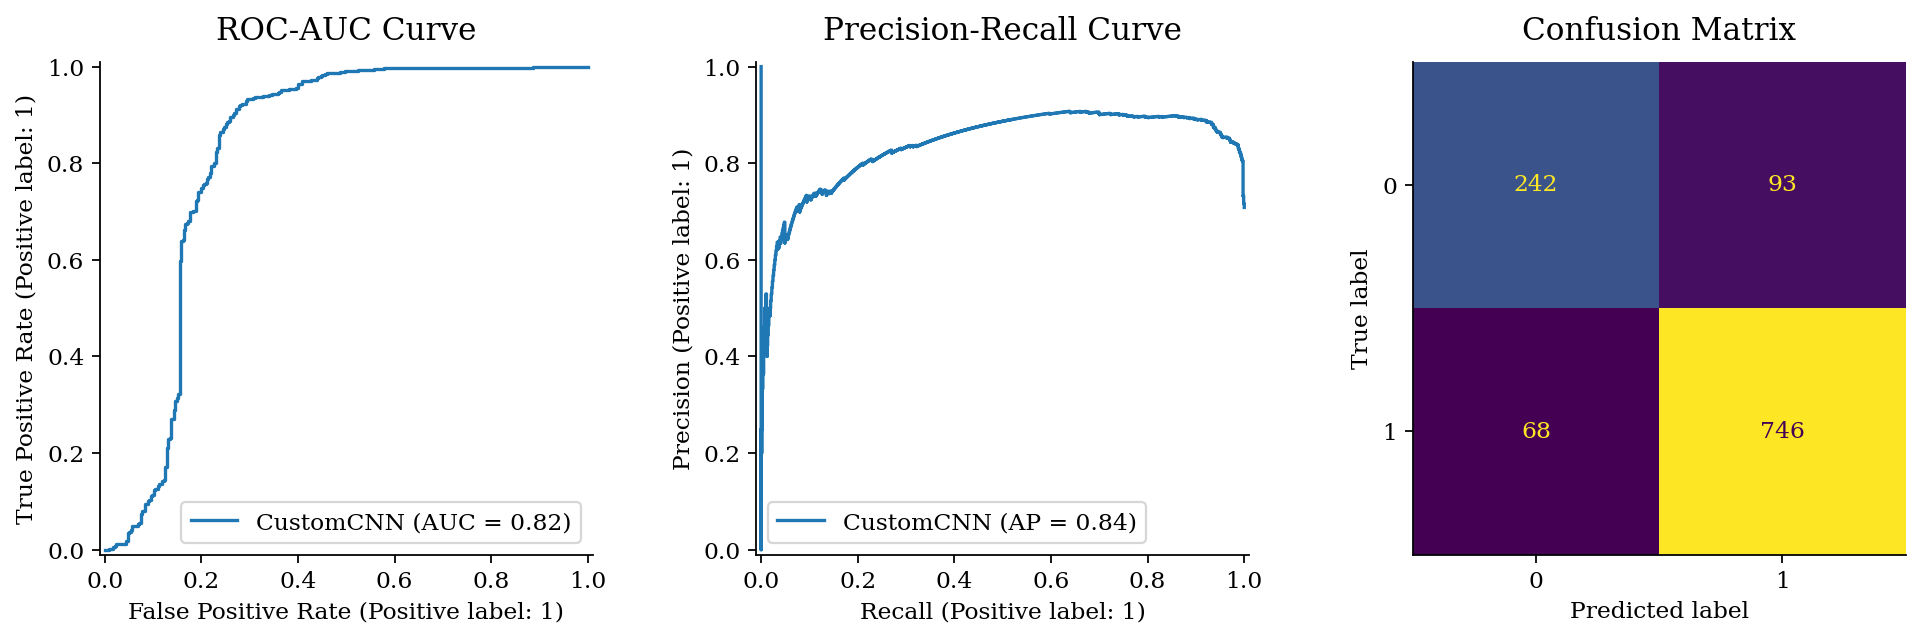

In [69]:
evaluate_model(custom_model)

The overall performance is quite good for a light-weight CNN trained on limited data. There are relatively few *false positives (86)* and *false negatives (81)*.

In [ ]:
plot_predictions(custom_model)

In [73]:
pretrained_mobnet_base = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_mobnet_base.trainable = False

mobnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # MobileNet
    layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input),
    pretrained_mobnet_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="MobileNetV3")
mobnet_model.summary()

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_brightness_3                  │ (None, 224, 224, 3)         │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_3 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 960)                 │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         246,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,250,625 (12.40 MB)

 Trainable params: 254,273 (993.25 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - binary_accuracy: 0.6360 - loss: 0.7483 - roc_auc: 0.5770 - val_binary_accuracy: 0.7196 - val_loss: 0.5233 - val_roc_auc: 0.7937 - learning_rate: 0.0010
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - binary_accuracy: 0.7178 - loss: 0.5406 - roc_auc: 0.7553 - val_binary_accuracy: 0.7555 - val_loss: 0.5030 - val_roc_auc: 0.8412 - learning_rate: 0.0010
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - binary_accuracy: 0.7398 - loss: 0.5242 - roc_auc: 0.7756 - val_binary_accuracy: 0.7648 - val_loss: 0.4637 - val_roc_auc: 0.8514 - learning_rate: 0.0010
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - binary_accuracy: 0.7811 - loss: 0.4761 - roc_auc: 0.8224 - val_binary_accuracy: 0.7835 - val_loss: 0.4309 - val_roc_auc: 0.8706 - learning_rate: 0.0010
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - binary_accuracy: 0.7415 - loss: 0.5104 - roc_auc: 0.8012 - val_binary_accuracy: 0.7850 - val_loss: 0.4416 - val_roc_auc: 0.8695

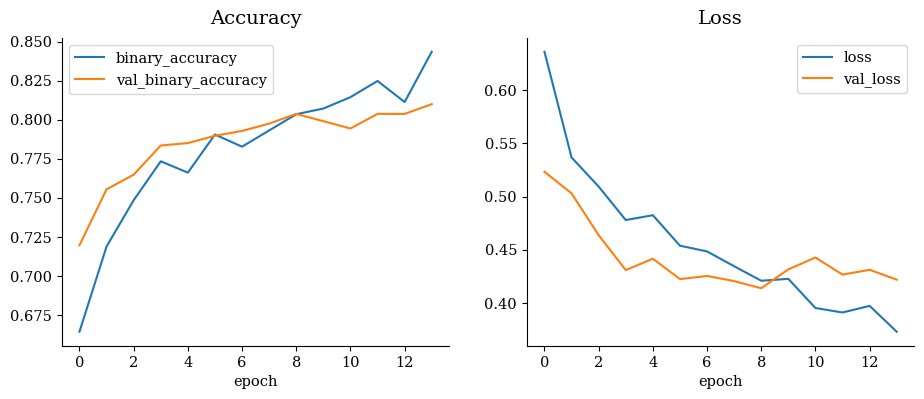

In [74]:
mobnet_history = compile_and_fit_model(mobnet_model)


ROC-AUC:   0.74643
Accuracy:  0.73020
Loss:      0.55330



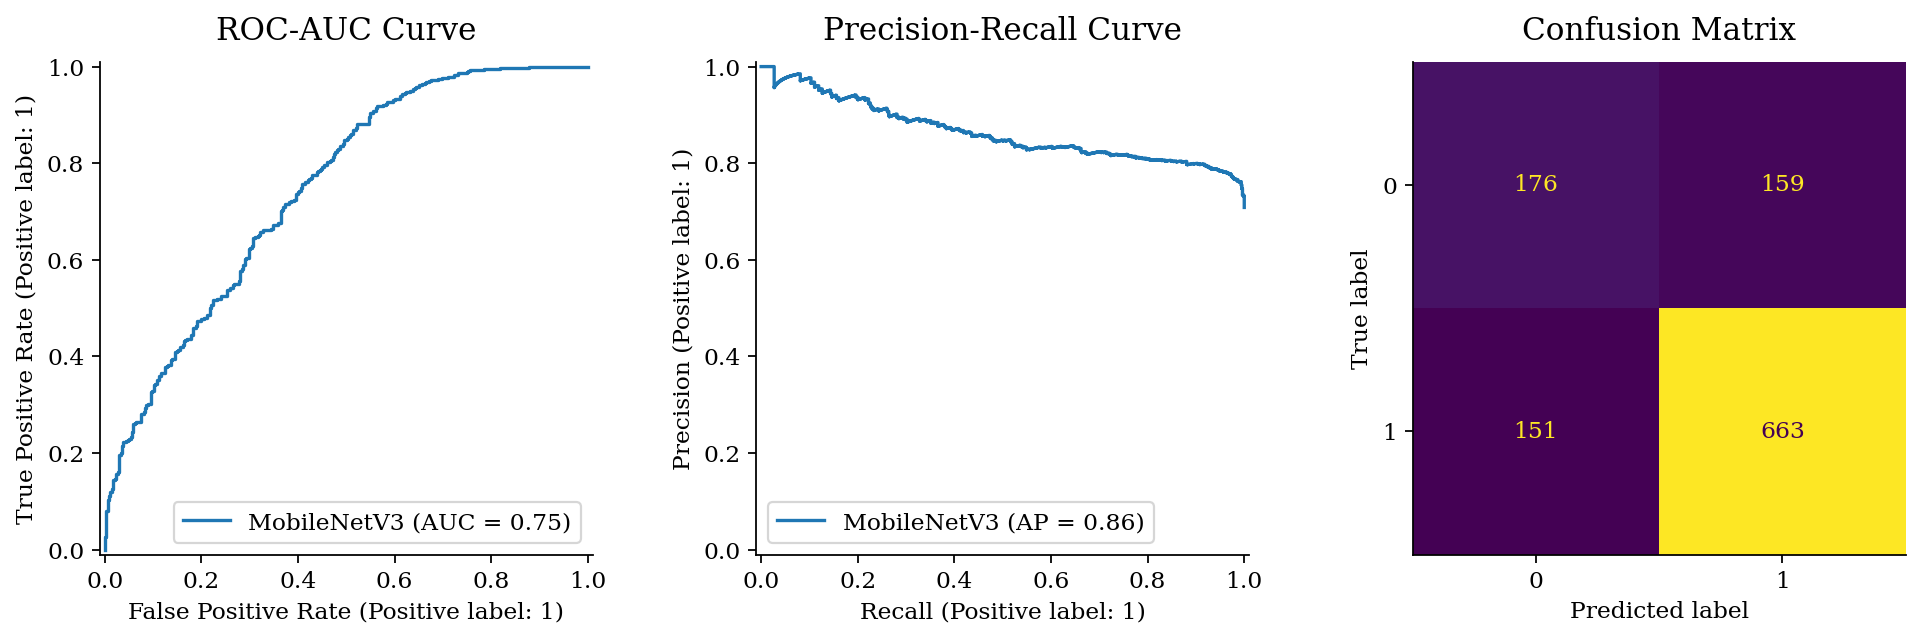

In [75]:
evaluate_model(mobnet_model)

There are a lot of *false positives (190)*. Many healthy women would get a false alarm.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: [1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1]
Actual:    [1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1]


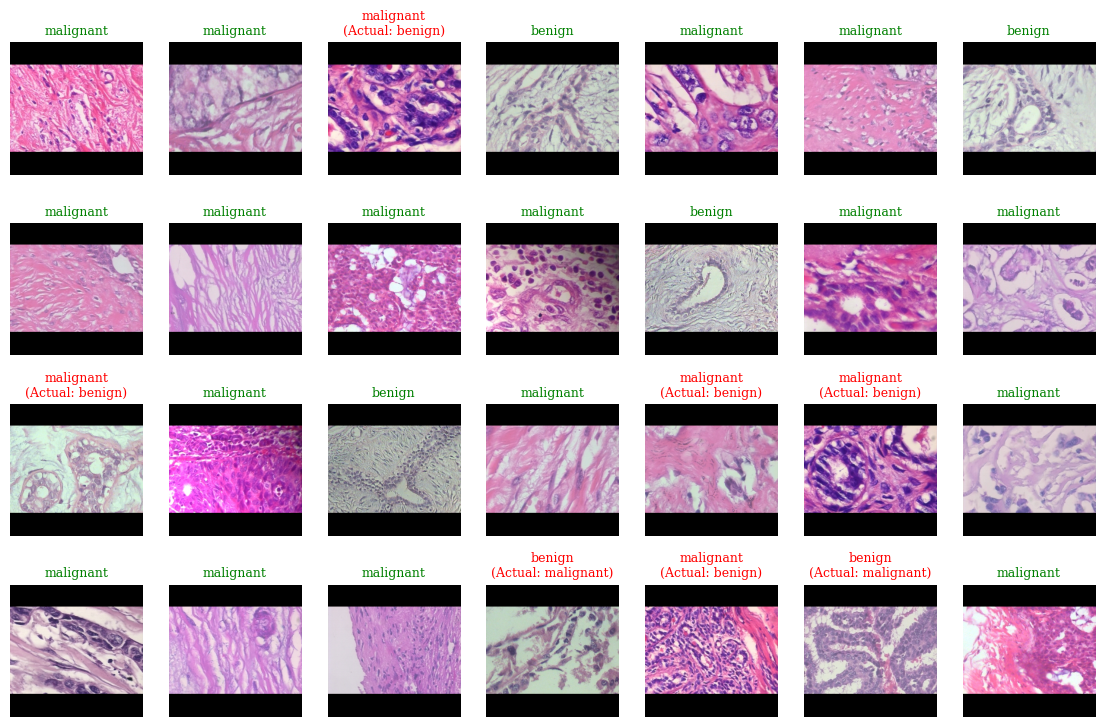

In [76]:
plot_predictions(mobnet_model)

## Model with EfficientNetB1 base

EfficientNet paper: <https://arxiv.org/abs/1905.11946>

In [77]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # EfficientNet
    pretrained_efficientnet_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="EfficientNetB1")
efficientnet_model.summary()

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_brightness_4                  │ (None, 224, 224, 3)         │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_4 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_4 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b1 (Functional)       │ (None, 1280)                │       6,931,124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,267,317 (27.72 MB)

 Trainable params: 336,193 (1.28 MB)

 Non-trainable params: 6,931,124 (26.44 MB)

Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - binary_accuracy: 0.7098 - loss: 0.5865 - roc_auc: 0.6947 - val_binary_accuracy: 0.7804 - val_loss: 0.4352 - val_roc_auc: 0.9016 - learning_rate: 0.0010
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - binary_accuracy: 0.8024 - loss: 0.4316 - roc_auc: 0.8674 - val_binary_accuracy: 0.8411 - val_loss: 0.3700 - val_roc_auc: 0.9255 - learning_rate: 0.0010
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - binary_accuracy: 0.8297 - loss: 0.3921 - roc_auc: 0.8819 - val_binary_accuracy: 0.8785 - val_loss: 0.3238 - val_roc_auc: 0.9398 - learning_rate: 0.0010
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - binary_accuracy: 0.8216 - loss: 0.4020 - roc_auc: 0.8787 - val_binary_accuracy: 0.8427 - val_loss: 0.3506 - val_roc_auc: 0.9294 - learning_rate: 0.0010
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - binary_accuracy: 0.8489 - loss: 0.3572 - roc_auc: 0.9097 - val_binary_accuracy: 0.8692 - val_loss: 0.3344 - val_roc_auc: 0.9279

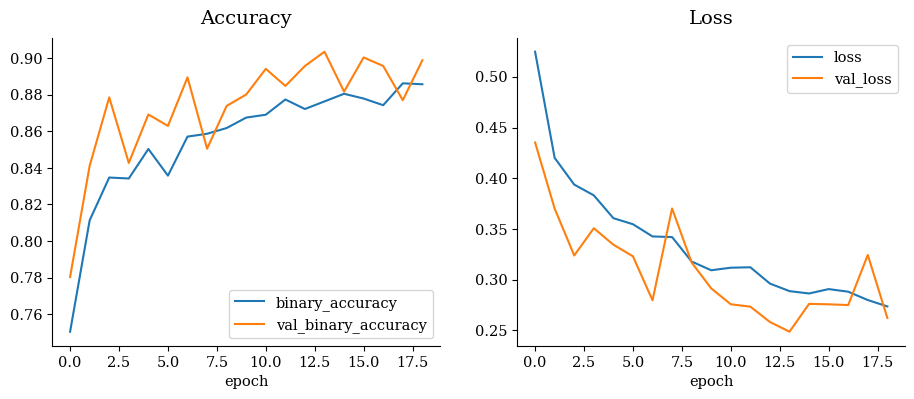

In [78]:
efficientnet_history = compile_and_fit_model(efficientnet_model)


ROC-AUC:   0.87560
Accuracy:  0.79983
Loss:      0.45626



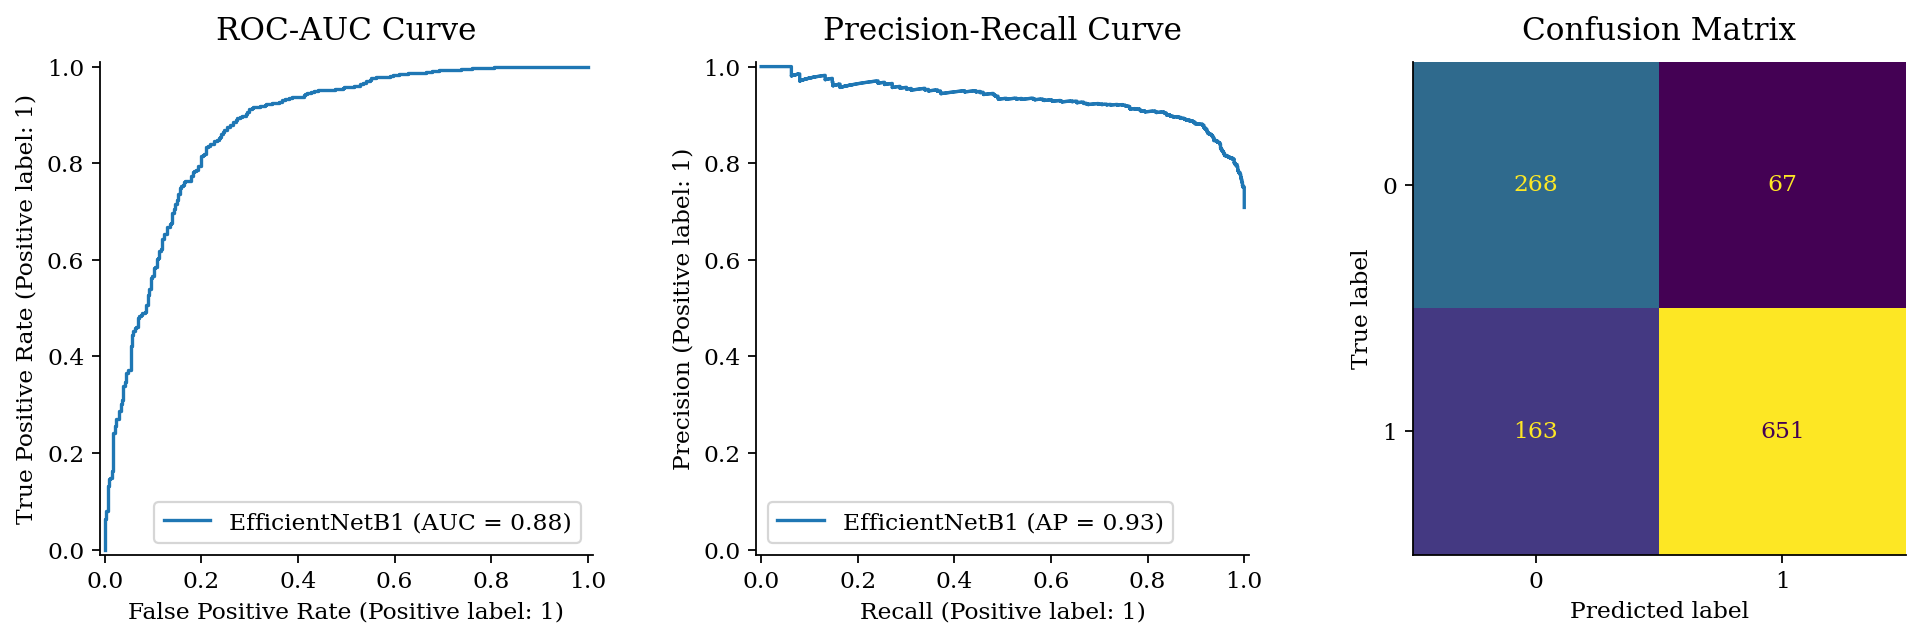

In [79]:
evaluate_model(efficientnet_model)

This model is very promising. It has attained the highest test ROC-AUC score so far. But the number of *false positives (120)* is a concern. There is room for improvement.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: [1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1]
Actual:    [1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1]


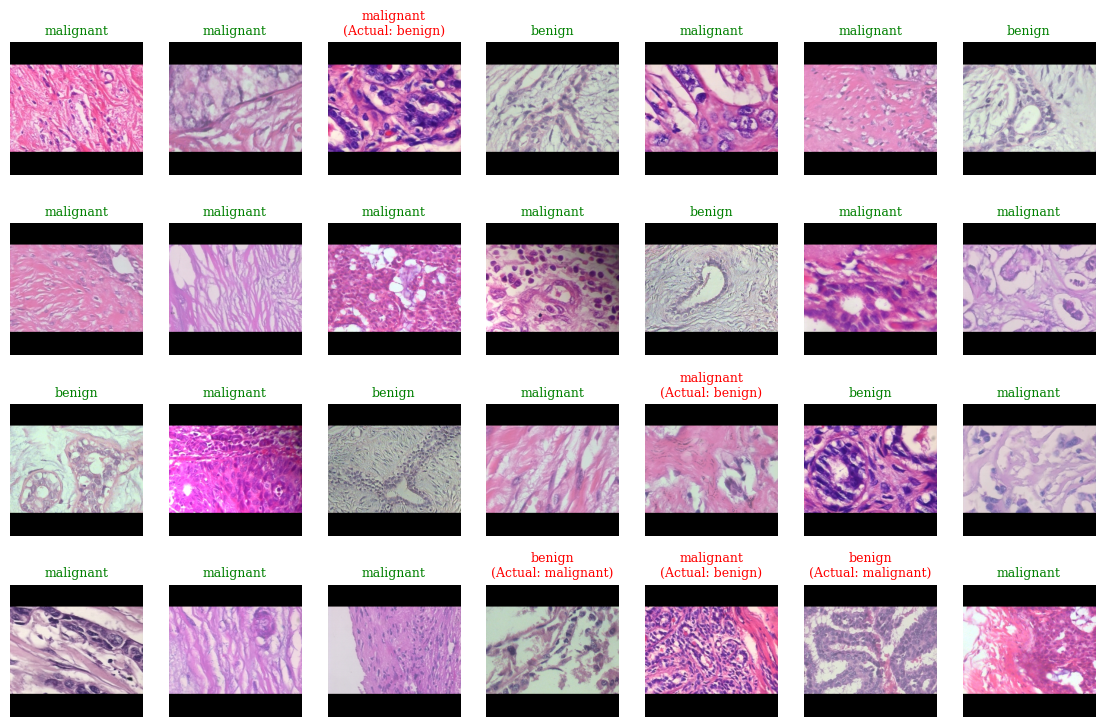

In [80]:
plot_predictions(efficientnet_model)

## Model with VGG16 base

VGG paper: <https://arxiv.org/abs/1409.1556>

In [81]:
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_vgg16_base.trainable = False

vgg16_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # VGG16
    layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(384, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="VGG16")
vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_brightness_5                  │ (None, 224, 224, 3)         │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_5 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_5 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 384)                 │         196,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,936,385 (56.98 MB)

 Trainable params: 221,697 (866.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
plot_predictions(resnet_model)

# Model Evaluation

The EfficientNetB1 model achieved the least loss (0.386096) and highest ROC-AUC score (0.876673) on the test dataset.

The custom CNN model attained the highest accuracy score (0.854656).

In [88]:
fitted_models = [custom_model, mobnet_model, efficientnet_model]

# Ensure all models are compiled before evaluation
for model in fitted_models:
    if not model.built:  # Check if the model has been built
        model.build(input_shape=(IMG_SIZE, IMG_SIZE, 3))  # Build if necessary
    if not model.compiled:  # Use 'compiled' property instead of '_is_compiled'
        # If not compiled, compile it.
        # You'll need to adjust the optimizer, loss, and metrics if needed
        model.compile(
            optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.AUC(name="roc_auc"), "binary_accuracy"]
        )

test_metrics = pd.DataFrame(
    {model.name: model.evaluate(test_ds, verbose=0) for model in fitted_models},
    index=["Loss", "ROC-AUC", "Accuracy"]
)
test_metrics.style.highlight_min(color="gold", axis=None)\
                  .highlight_max(color="lawngreen", axis=None)

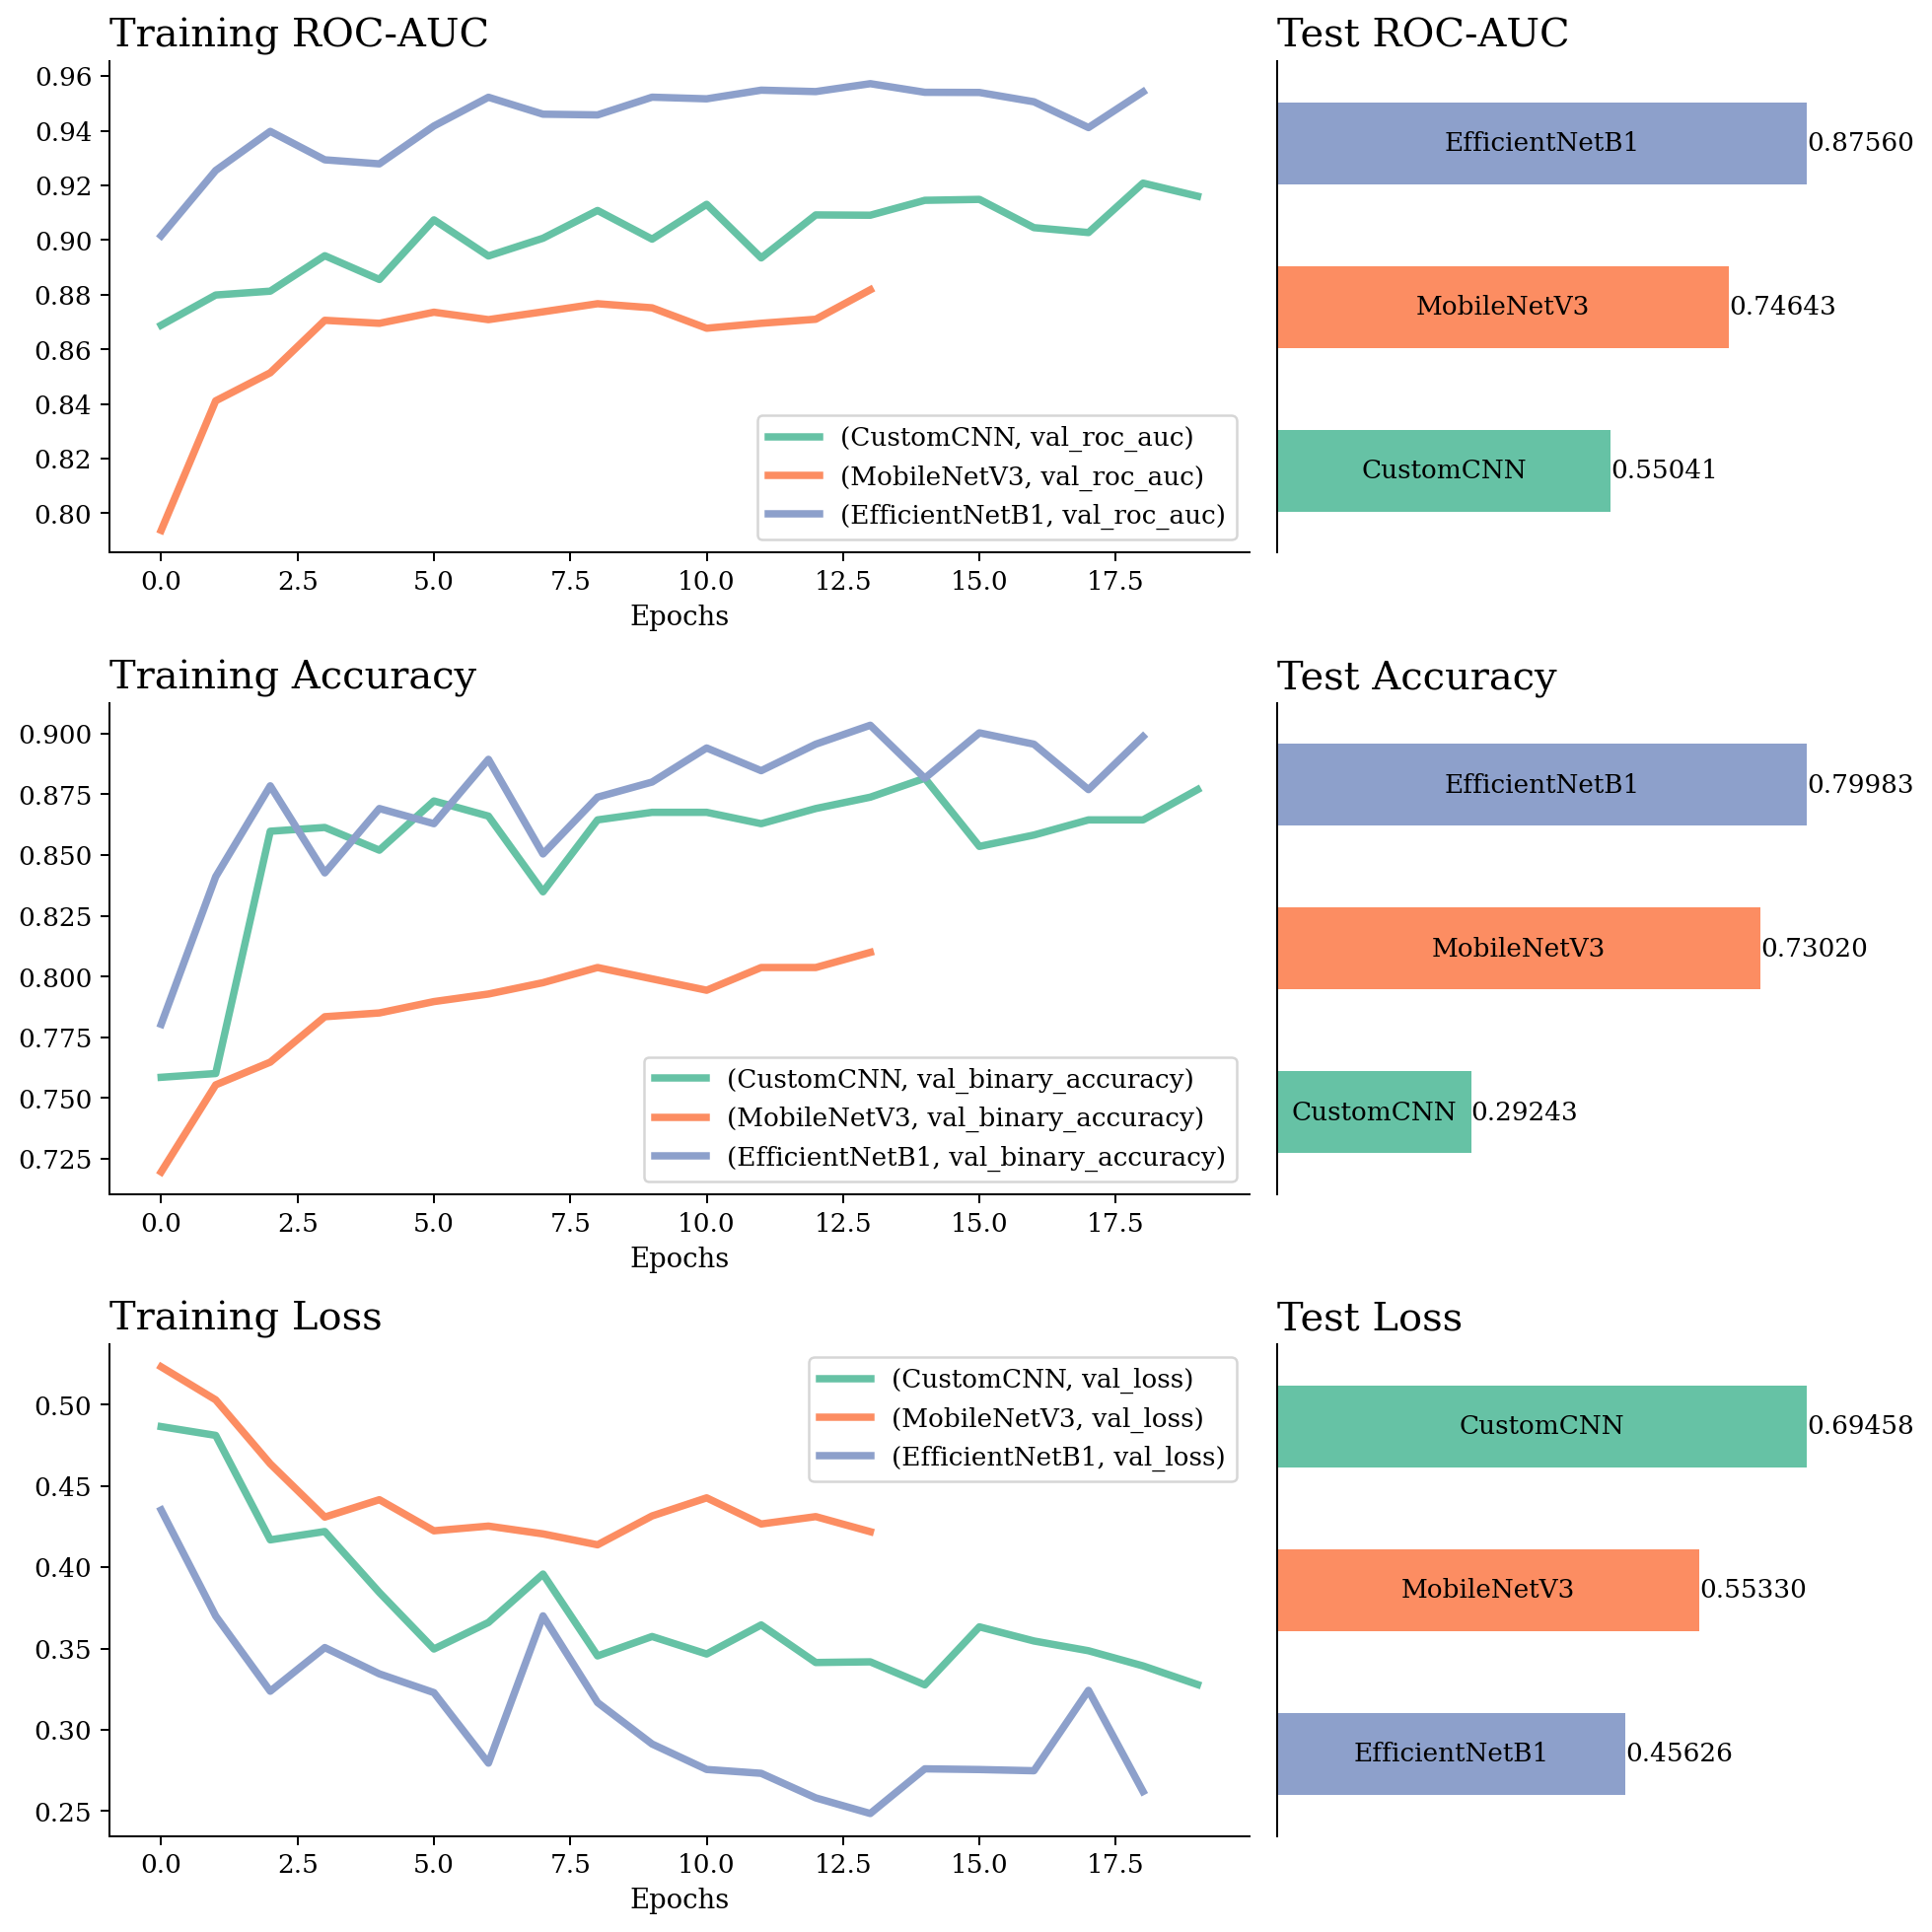

In [89]:
# Process training metrics
hist_list = [custom_history, mobnet_history, efficientnet_history]
train_metrics = pd.concat([pd.DataFrame(hist.history) for hist in hist_list],
                          axis=1, keys=[hist.model.name for hist in hist_list])
train_metrics.head()
color_dict = dict(zip(test_metrics, plt.colormaps["Set2"].colors))

# Plot training and test metrics
fig, axes = plt.subplot_mosaic("\naab\nccd\neef\n", figsize=(11, 11),
                               dpi=180, tight_layout=True)
for ax, metric in zip([axes["a"], axes["c"], axes["e"]],
                      ["val_roc_auc", "val_binary_accuracy", "val_loss"]):
    data_ = train_metrics.filter(like=metric)
    data_.plot(ax=ax, lw=3, color=[color_dict[col]
                                   for col in data_.columns.levels[0]])
    ax.set_xlabel("Epochs", size=11)

for ax, metric in zip([axes["b"], axes["d"], axes["f"]],
                      ["ROC-AUC", "Accuracy", "Loss"]):
    data_ = test_metrics.loc[metric].sort_values()
    data_.plot.barh(ax=ax, color=[color_dict[col] for col in data_.index])
    ax.bar_label(ax.containers[0], [f"{x:.5f}" for x in ax.containers[0].datavalues])
    ax.bar_label(ax.containers[0], data_.index, label_type="center")
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.spines["bottom"].set_visible(False)

titles = ["Training ROC-AUC", "Test ROC-AUC", "Training Accuracy", "Test Accuracy",
          "Training Loss", "Test Loss"]
for ax, title in zip(axes.values(), titles):
    ax.set_title(title, size=16, loc="left")

axes["a"].legend(title="")
axes["c"].legend(title="")
axes["e"].legend(title="");

In [ ]:
stacking_model = LogisticRegressionCV(scoring="roc_auc")
stacking_model.fit(train_preds, train_labels)
stacked_preds = stacking_model.predict_proba(test_preds)

test_metrics["Stacking Ensemble"] = [
    metrics.log_loss(test_labels, stacked_preds),
    metrics.roc_auc_score(test_labels,
                          stacked_preds[:, 1]), # get stacked +ve probability
    metrics.accuracy_score(test_labels,
                           stacked_preds.argmax(axis=1)) # get stacked predicted label
]
test_metrics.style.highlight_min(color="gold", axis=None)\
                  .highlight_max(color="lawngreen", axis=None)

The stacked ensemble significantly improves the test ROC-AUC score, but the EfficientNetB1 model still yields the least loss.

In [ ]:
# Store models for deployment
custom_model.save("custom_cnn.h5")
mobnet_model.save("mobnetv3sm.h5")
efficientnet_model.save("efficientnetv2B1.h5")
